# Exp10. DCGAN으로 CIFAR-10 이미지 생성하기
GAN에는 두 가지 네트워크가 있다. 
- `생성자(Generator)`는 아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를 생성해낸다. 즉, 무에서 유를 창조하는 것과 같다. 
- `판별자(Discriminator)`는 기존에 있던 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 각 이미지가 Real인지, Fake인지에 대한 판단 정도를 실수값으로 출력한다.  

## 1. module import / load dataset

In [1]:
import os
import glob
import time

import cv2
import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

In [3]:
train_x.shape

(50000, 32, 32, 3)

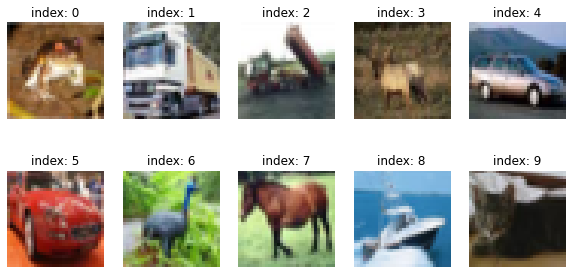

In [4]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i])
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

In [5]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [6]:
train_x = (train_x - 127.5) / 127.5  # 이미지 [-1, 1]로 정규화

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [7]:
BUFFER_SIZE = 50000  # 전체 데이터를 섞기 위해 설정
BATCH_SIZE = 256  # 한 번에 학습할 데이터의 양

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 2. Generator Model

In [8]:
def make_generator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    
    return model

In [9]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [10]:
noise = tf.random.normal([1, 100])

In [11]:
# 텐서플로우 2.0 이후 버전에서는 레이어와 모델에 call 메서드를 구현해 놓기 때문에,
# 방금 만들어진 생성자 모델에 입력값으로 노잊르르 넣고 바로 모델을 호출하면 간단히 결과 이미지가 생성된다. 
# 지금은 학습하는 중이 아니기 때문에 training=False를 설정해야 한다. 
# Batch Normalization 레이어는 훈련 시기와 추론(inference) 시기의 행동이 다르기 때문에 training=False를 줘야 올바른 결과를 얻을 수 있다. 
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

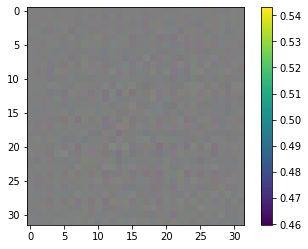

In [12]:
plt.imshow((generated_image[0, :, :, :] + 1) / 2)  # [-1, 1] -> [0, 1]
plt.colorbar()
plt.show()

## 3. Discriminator Model

In [13]:
def make_discriminator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    # Fourth: Dense Layer
    model.add(layers.Dense(3))
    
    return model

In [14]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [15]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 1.8094681e-03, -7.3163130e-05, -5.6664511e-03]], dtype=float32)>

- 텐서플로우의 텐서 형태로 출력되었다. 이 값 또한 아직은 아무런 의미가 없을 것이다. 

## 4. Loss Function
GAN은 손실함수로 교차 엔트로피(Cross Entropy)를 사용한다. 교차 엔트로피는 분류 모델을 설계할 때 많이 사용했던 손실함수로, 점점 가까워지기 시작하는 두 값이 얼마나 큰 차이가 있는지 정량적으로 계산할 때 많이 쓰인다. 특히 판별자는 한 개의 이미지가 가짜인지 진짜인지 나타내는 2개 클래스 간 분류 문제를 풀어야 하므로, 이진 교차 엔트로피(binary cross entropy)를 사용할 것이다. 

In [16]:
# 교차 엔트로피를 계산하기 위해 입력할 값은 판별자가 판별한 값인데, 판별자 모델의 마지막 레이어에는 값을 정규화시키는 sigmoid나 tanh 같은 활성화 함수가 없다. 
# 즉, 판별자가 출력하는 값은 범위가 정해지지 않아 모든 실수값을 가질 수 있다. 
# tf.keras.losses의 BinaryCrossentropy 클래스는 기본적으로 인풋값이 0에서 1사이에 분포하는 확률값이라 가정한다. 
# 따라서 from_logits를 True로 설정해줘야 BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid 함수를 사용해 정규화하고 계산할 수 있다. 

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### generator_loss
- `generator_loss`는 `fake_output`이 1에 가까워지기 바라므로, `tf.ones_like`와의 교차 엔트로피값을 계산하면 된다.

In [17]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### discriminator_loss
- 반면, `discriminator_loss`는 `real_output` 값은 1에 가까워지기를, `fake_output` 값은 0에 가까워지기를 바라므로 두 가지 loss 값을 모두 계산한다. 

In [18]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### discriminator accuarcy
- 판별자가 real_output, fake_output을 얼마나 정확히 판별하는지 accuarcy를 계산해 보는 것도 GAN의 학습에서 매우 중요하다. 
- 판별자가 real_output과 fake_output을 accuracy가 1에 가깝게 정확히 판별해 낸다해도 좋은 것은 아니다. 이 경우 생성자가 만들어내는 fake_output이 real_output과 차이가 많이 나기 때문에 매우 쉽게 판별해내고 있다는 뜻이기 때문이다. 
- 따라서, real accuracy와 fake accuracy가 초반에는 1에 가깝게 나오다가, 서서히 낮아져 둘 다 0.5에 가까워지는 것이 이상적이다. 

In [19]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

## 5. Optimizer
- 생성자와 구분자는 따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 따로 만들어줘야 한다. 

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [21]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

- 매번 학습이 어떻게 진행되어가고 있는지를 확인하기 위해 생성자가 생성한 샘플을 확인해보자. 
- 샘플은 한 번에 16장으로, 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즐르 만들어야 한다. 
- 즉, 100차원의 노이즈를 총 16개, `(16, 100)` 형상의 벡터를 만들어 두자. 

## 6. Training
`@tf.function` 데코레이터가 사용된 함수에 입력된 입력은 Tensorflow의 graph 노드가 될 수있는 타입으로 자동 변환된다. 

In [22]:
@tf.function
def train_step(images):  # (1) 입력 데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  # (2) 생성자 입력 노이즈
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  # (3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  # (4) generated_image 생성
        
        # (5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        # (6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        # (7) accuarcy 계산
        real_accuracy, fake_accuarcy = discriminator_accuracy(real_output, fake_output)
        
    # (8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    # (9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuarcy  # (10) 리턴 값

In [23]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :] + 1) / 2)
        plt.axis=('off')
        
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [24]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6. # matlab 차트의 기본 크기를 15, 6으로 지정

def draw_train_history(history, epoch):
    # summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model_loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')
    
    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장한다. 
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [25]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

- 정기적으로 모델을 저장하기 위한 checkpoint 생성
- `tf.train.Checkpoint`를 활용하면 매번 모델을 직접 저장해 주지 않아도, 코드 한 줄로 빠르고 편하게 버전을 관리할 수 있다. 
- checkpoint에는 optimizer와 생성자, 판별자를 모두 넣어 저장한다. 정확히는 생성자와 판별자가 학습한 모델 가중치를 저장한다. 

In [26]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [27]:
save_every = 5
EPOCHS = 100

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

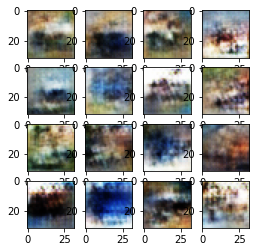

Time for training : 1839 sec


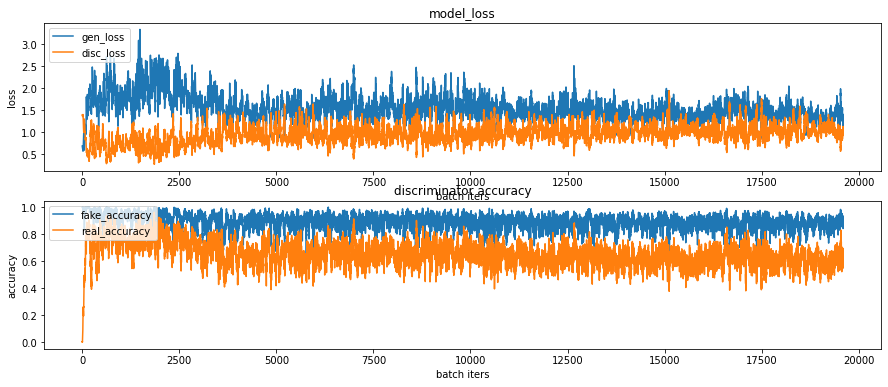

CPU times: user 31min 21s, sys: 2min 36s, total: 33min 57s
Wall time: 30min 40s


In [28]:
%%time
train(train_dataset, EPOCHS, save_every)

In [29]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif

-rw-r--r-- 1 root root 1576823 Feb  8 07:09 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif
